# End-to-End Machine Learning Regression Project  
## California Housing Price Prediction

**Author:** Duvan Mendoza  
**Project Type:** Supervised Machine Learning – Regression  
**Purpose:** Portfolio & Job Applications  

---

This project implements a complete **end-to-end Machine Learning pipeline** to predict **median house prices in California districts** using socio-economic and geographical features.

The project follows a real-world Machine Learning workflow including:
- Data ingestion  
- Exploratory Data Analysis (EDA)  
- Feature engineering  
- Advanced preprocessing pipelines  
- Model training and evaluation  
- Hyperparameter tuning  
- Final model validation and persistence  

This notebook is based on the public California Housing dataset and **extends the classic end-to-end ML example from the book**:

*Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow* — Aurélien Géron  

The implementation, execution, documentation, and analysis were performed by me as part of my professional ML / Data Science portfolio.


## 1. Project Objective and Scope

### Problem Definition
- **Task Type:** Regression  
- **Target Variable:** Median house value  
- **Goal:** Predict housing prices in California districts as accurately as possible using structured socio-economic and geographical data.

### Dataset Description
Each row in the dataset represents a **California district** with features such as:
- Median income  
- Housing age  
- Total rooms and bedrooms  
- Population and household size  
- Latitude and longitude  
- Proximity to the ocean  

### Technical Objectives
This project demonstrates:
- Robust **data ingestion and validation**
- Structured **Exploratory Data Analysis (EDA)**
- Advanced **feature engineering**
- Use of **scikit-learn Pipelines and ColumnTransformers**
- Training and comparison of **multiple regression models**
- Model evaluation with **RMSE and cross-validation**
- Hyperparameter tuning using **GridSearchCV and RandomizedSearchCV**
- Final model persistence for deployment

The objective is both **high predictive performance** and **clean ML engineering practices**.


# Get the Data

## Download the Data

In [1]:
# Core libraries
from pathlib import Path
import tarfile
import urllib.request

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# Scikit-learn: model selection, preprocessing, models, metrics
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Statistical tools
from scipy import stats
from scipy.stats import randint

# Model persistence
import joblib

# Plot style
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## ## 2. Data Ingestion

In this section, I download and load the **California Housing Dataset** from a public GitHub repository.  
The dataset is stored locally in a `datasets/` folder to make the project reproducible.


In [27]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
        housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()
housing.head()

/tmp/ipython-input-2931591054.py:8: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tarball.extractall(path="datasets")


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## 3. Initial Data Exploration

Here I perform a quick inspection of:
- Data types  
- Missing values  
- Basic descriptive statistics  
- Categorical feature distributions  

This helps identify potential data quality issues early.

In [28]:
housing.info()
print("\nCategorical value counts (ocean_proximity):")
print(housing["ocean_proximity"].value_counts())

housing.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB

Categorical value counts (ocean_proximity):
ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64


,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


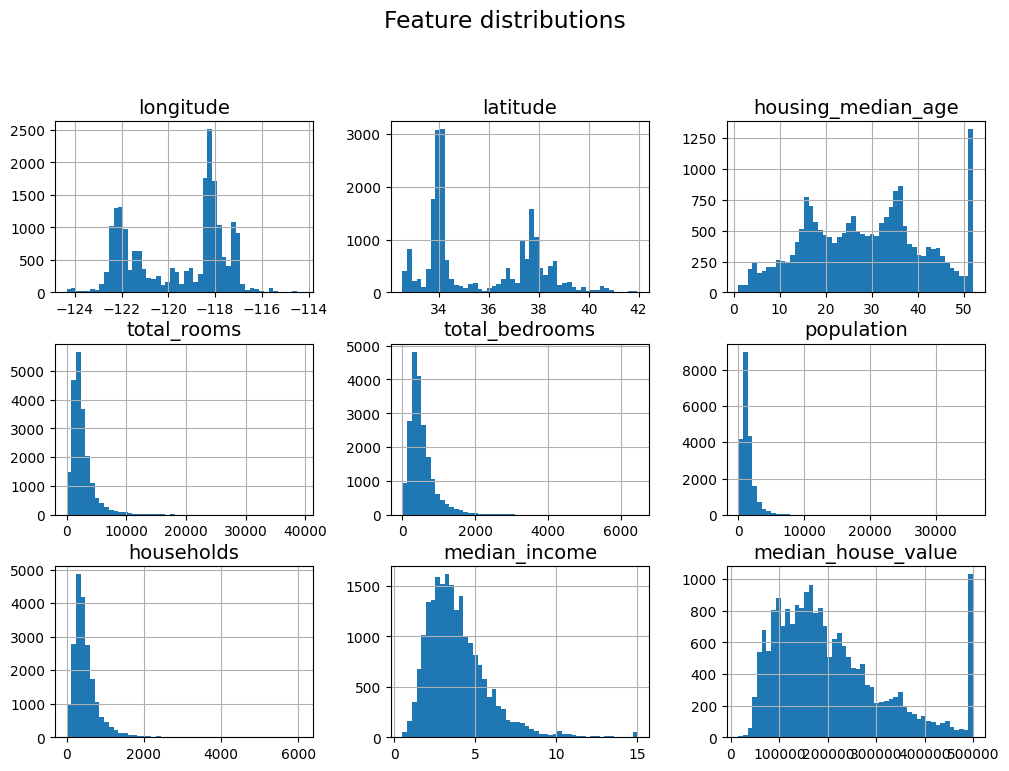

In [29]:
housing.hist(bins=50, figsize=(12, 8))
plt.suptitle("Feature distributions", y=1.02)
plt.show()

## 4. Train/Test Split with Stratified Sampling

To evaluate the model fairly, I split the dataset into:
- **Training set (80%)**
- **Test set (20%)**

Since **median income** is a key predictor, I create an **income category** and use **stratified sampling** to ensure the income distribution is similar in both sets.

In [5]:
# Create income category for stratified sampling
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)

housing["income_cat"].value_counts().sort_index()

,count
income_cat,
1,822
2,6581
3,7236
4,3639
5,2362


In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(
    n_splits=1, test_size=0.2, random_state=RANDOM_STATE
)

for train_idx, test_idx in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_idx].copy()
    strat_test_set = housing.loc[test_idx].copy()

# Drop helper column
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN


## 5. Exploratory Data Analysis (EDA)

In this section, I explore:
- The geographical distribution of districts  
- The relationship between location, population, and house prices  
- Correlations between features and the target variable  
- Useful engineered features (ratios)

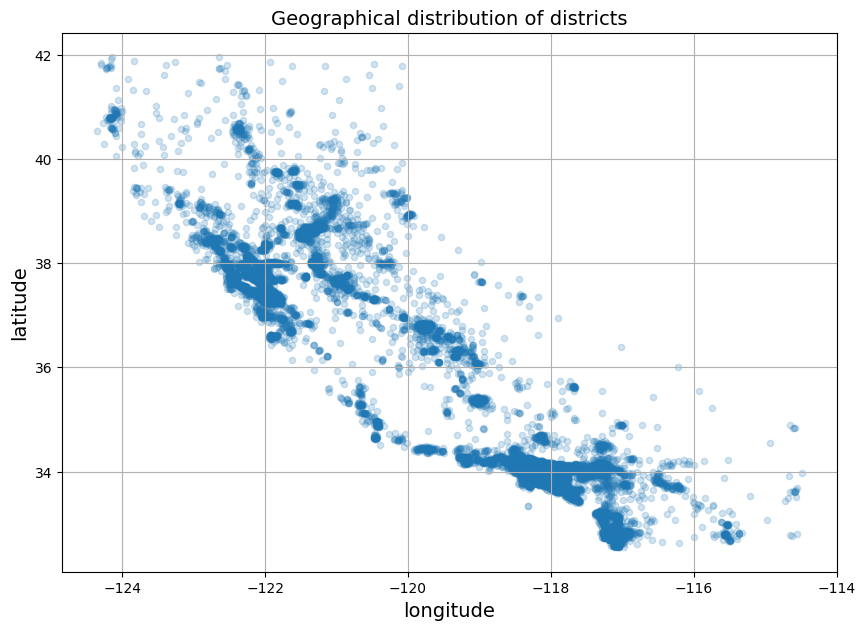

In [7]:
housing = strat_train_set.copy()

housing.plot(
    kind="scatter", x="longitude", y="latitude", grid=True,
    alpha=0.2, figsize=(10, 7)
)
plt.title("Geographical distribution of districts")
plt.show()

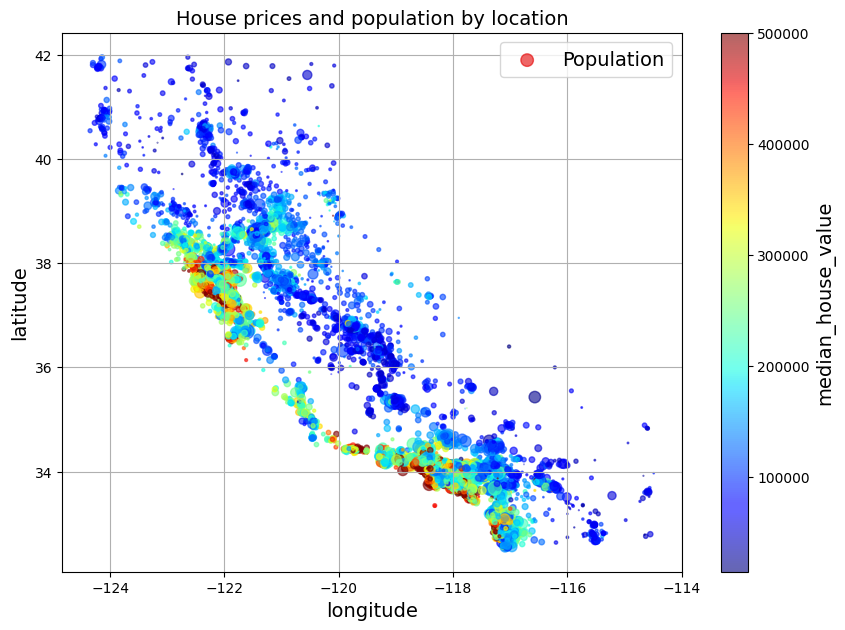

In [8]:
housing.plot(
    kind="scatter", x="longitude", y="latitude", grid=True,
    s=housing["population"] / 100,
    label="Population",
    c="median_house_value",
    cmap="jet", colorbar=True,
    figsize=(10, 7), alpha=0.6
)
plt.legend()
plt.title("House prices and population by location")
plt.show()

In [9]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688380
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
population,-0.020153
longitude,-0.050859
latitude,-0.139584


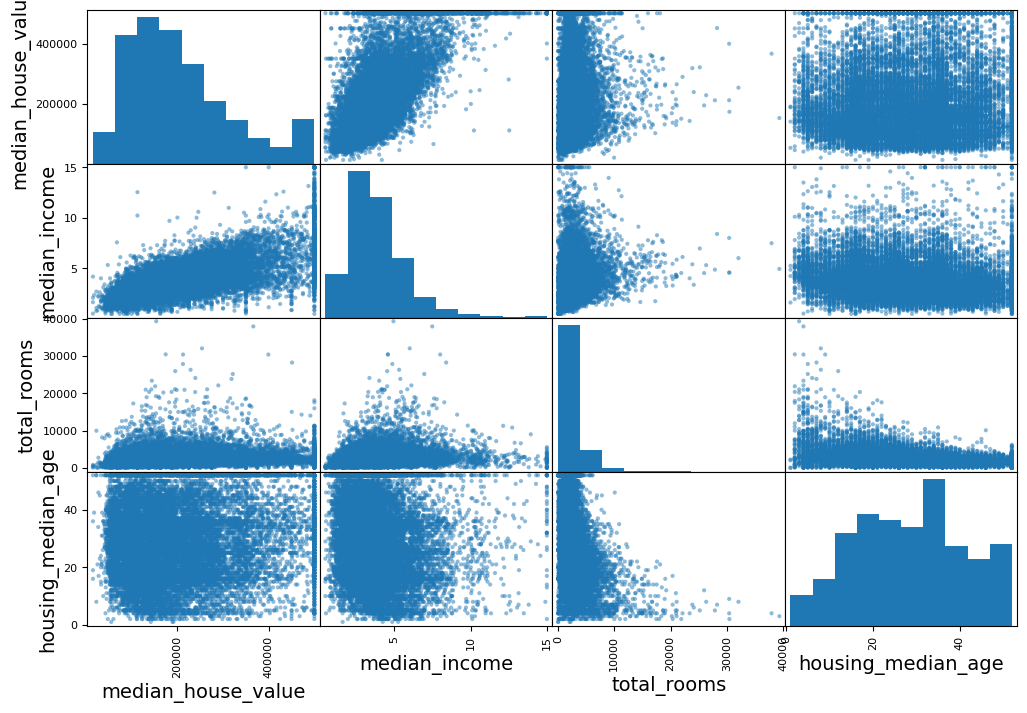

In [10]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

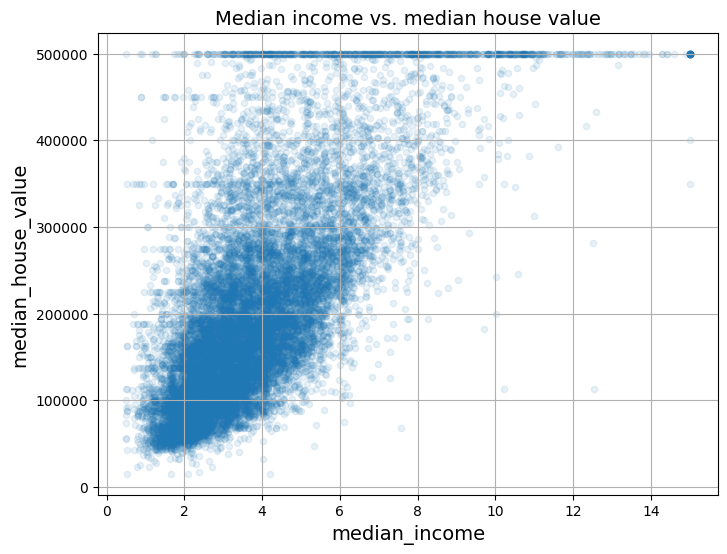

In [11]:
housing.plot(
    kind="scatter", x="median_income", y="median_house_value",
    alpha=0.1, grid=True, figsize=(8, 6)
)
plt.title("Median income vs. median house value")
plt.show()

## 6. Feature Engineering

Some additional features can help the model capture more structure in the data.  
Here I create:

- `rooms_per_house` = total_rooms / households  
- `bedrooms_ratio` = total_bedrooms / total_rooms  
- `people_per_house` = population / households  

These engineered features often correlate more strongly with the target than the raw counts.

In [30]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688075
rooms_per_house,0.151948
total_rooms,0.134153
housing_median_age,0.105623
households,0.065843
total_bedrooms,0.049686
people_per_house,-0.023737
population,-0.024650
longitude,-0.045967


## 7. Train/Label Split

Before building preprocessing pipelines, I separate:
- **Features (X):** all predictors  
- **Labels (y):** `median_house_value`

In [13]:
housing_labels = housing["median_house_value"].copy()
housing_features = housing.drop("median_house_value", axis=1)

housing_features.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_house,bedrooms_ratio,people_per_house
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY,3.211799,0.335742,1.524178
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN,5.504202,0.180153,1.865546
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND,5.334975,0.200369,2.768473
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND,5.351282,0.203881,2.365385
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN,3.725256,0.277371,1.631399


## 8. Data Preprocessing Pipeline

To make the workflow robust and reproducible, I use scikit-learn **Pipelines** and **ColumnTransformer**:

- For numerical features:
  - Impute missing values with the median
  - Standardize features (mean 0, std 1)

- For categorical features:
  - Impute missing values with the most frequent category
  - One-Hot Encoding

All preprocessing is applied consistently to training, validation, and test data.

In [14]:
# Select numerical and categorical columns
num_attribs = housing_features.select_dtypes(include=[np.number]).columns.tolist()
cat_attribs = housing_features.select_dtypes(include=["object"]).columns.tolist()

num_attribs, cat_attribs

(['longitude',
  'latitude',
  'housing_median_age',
  'total_rooms',
  'total_bedrooms',
  'population',
  'households',
  'median_income',
  'rooms_per_house',
  'bedrooms_ratio',
  'people_per_house'],
 ['ocean_proximity'])

In [15]:
# Numerical pipeline
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

# Categorical pipeline
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

# Full preprocessing
preprocessing = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ]
)

housing_prepared = preprocessing.fit_transform(housing_features)
housing_prepared.shape

(16512, 16)

## 9. Baseline Models and Cross-Validation

I start by training a few baseline models using the same preprocessing pipeline:

- **Linear Regression**
- **Decision Tree Regressor**
- **Random Forest Regressor**

Each model is evaluated using **10-fold Cross-Validation** and **RMSE**.

In [34]:
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

In [35]:
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing_features, housing_labels)

lin_scores = -cross_val_score(
    lin_reg, housing_features, housing_labels,
    scoring="neg_root_mean_squared_error",
    cv=10
)

print("Linear Regression - RMSE (mean):", lin_scores.mean())
print("Linear Regression - RMSE (std): ", lin_scores.std())

Linear Regression - RMSE (mean): 67398.92658392523
Linear Regression - RMSE (std):  1230.730267685793


In [36]:
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=RANDOM_STATE))
tree_scores = -cross_val_score(
    tree_reg, housing_features, housing_labels,
    scoring="neg_root_mean_squared_error",
    cv=10
)

print("Decision Tree - RMSE (mean):", tree_scores.mean())
print("Decision Tree - RMSE (std): ", tree_scores.std())

Decision Tree - RMSE (mean): 69343.54393240904
Decision Tree - RMSE (std):  1737.5744502919472


In [37]:
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=RANDOM_STATE))
forest_scores = -cross_val_score(
    forest_reg, housing_features, housing_labels,
    scoring="neg_root_mean_squared_error",
    cv=10
)

print("Random Forest - RMSE (mean):", forest_scores.mean())
print("Random Forest - RMSE (std): ", forest_scores.std())

Random Forest - RMSE (mean): 49589.90655280846
Random Forest - RMSE (std):  972.0705142132862


## 10. Hyperparameter Tuning (Random Forest)

Since Random Forest performs best among the baseline models, I focus on tuning its hyperparameters using **RandomizedSearchCV**.

The hyperparameters explored include:
- `n_estimators`
- `max_depth`
- `max_features`
- `min_samples_split`
- `min_samples_leaf`

In [39]:
# Pipeline: preprocessing + RandomForest
rf_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=RANDOM_STATE)),
])

param_distributions = {
    "random_forest__n_estimators": randint(50, 200),
    "random_forest__max_depth": randint(5, 30),
    "random_forest__max_features": randint(4, len(num_attribs) + 1),
    "random_forest__min_samples_split": randint(2, 10),
    "random_forest__min_samples_leaf": randint(1, 10),
}

rnd_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    scoring="neg_root_mean_squared_error",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

rnd_search.fit(housing_features, housing_labels)

print("Best RMSE (CV):", -rnd_search.best_score_)
print("Best params:", rnd_search.best_params_)

Best RMSE (CV): 49137.24236906279
Best params: {'random_forest__max_depth': 21, 'random_forest__max_features': 6, 'random_forest__min_samples_leaf': 3, 'random_forest__min_samples_split': 5, 'random_forest__n_estimators': 104}


## 11. Final Model Evaluation on the Test Set

After hyperparameter tuning, I evaluate the best Random Forest model on the **held-out test set**, which was never used during training or tuning.

I also compute a **95% confidence interval** for the test RMSE using bootstrapping.

In [40]:
final_model = rnd_search.best_estimator_

test_set = strat_test_set.copy()

test_set["rooms_per_house"] = test_set["total_rooms"] / test_set["households"]
test_set["bedrooms_ratio"] = test_set["total_bedrooms"] / test_set["total_rooms"]
test_set["people_per_house"] = test_set["population"] / test_set["households"]

X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)
final_rmse = rmse(y_test, final_predictions)

final_rmse

np.float64(49355.72346930596)

In [42]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2

def rmse_from_se(squared_errors):
    return np.sqrt(np.mean(squared_errors))

boot_result = stats.bootstrap(
    (squared_errors,),
    rmse_from_se,
    confidence_level=confidence,
    random_state=RANDOM_STATE
)

rmse_lower, rmse_upper = boot_result.confidence_interval
rmse_lower, rmse_upper

(np.float64(47220.95997514305), np.float64(51719.31094437778))

(np.float64(47220.95997514305), np.float64(51719.31094437778))

## 12. Model Persistence and Example Predictions

The final model is saved using `joblib` so it can be reused in other scripts or deployed in a production environment.

In [43]:
joblib.dump(final_model, "california_housing_random_forest.pkl")

['california_housing_random_forest.pkl']

In [44]:
loaded_model = joblib.load("california_housing_random_forest.pkl")

sample_instances = X_test.iloc[:5]
sample_predictions = loaded_model.predict(sample_instances)

pd.DataFrame({
    "Predicted": sample_predictions,
    "Actual": y_test.iloc[:5].values
})

,Predicted,Actual
0,422148.899243,397700.0
1,207443.157291,202900.0
2,382040.582242,310000.0
3,313849.566851,314300.0
4,251015.415213,187500.0


## 13. Final Summary and Professional Takeaways

This project presented a complete **end-to-end Machine Learning regression pipeline** applied to the California Housing dataset.

### Final Model
- Final model: **Random Forest Regressor** tuned with **RandomizedSearchCV**
- Evaluated using **cross-validation** and a held-out **test set**
- Performance measured with **RMSE** and a **95% confidence interval**

### Key Technical Learnings
- Feature engineering and robust preprocessing have a major impact on performance  
- Cross-validation is essential to obtain reliable estimates of model quality  
- Pipelines and ColumnTransformer make ML workflows **reproducible and maintainable**  
- Hyperparameter tuning can significantly improve generalization compared to default settings  

---

This notebook is part of my **Machine Learning & Data Science professional portfolio** and reflects how I approach real-world regression problems from **data ingestion to model deployment readiness**.